# Light Field VR Data Analysis


## Read the raw data from .csv files

In [1]:
import pandas as pd
import os as os

# Get subject list from file names
data_dir='rawdata/'
files = os.listdir(data_dir)
subjects = [ f.split('_')[0] for f in files if 'votes.csv' in f ]

# Load the score data by subject
# Read votes from csv-files to Pandas DataFrames and concatenate
def read_votes(x):
    df = pd.read_csv(data_dir + x + '_votes.csv')
    df['Subject'] = x
    return df
df = pd.concat([ read_votes(s) for s in subjects ]).reset_index(drop=True)

# Parce stimulus names to Image, Codec and Bitrate
name_parsed = pd.DataFrame([ [s[:3],s[3:5],s[5:]] for s in df['Stimulus'] ],columns=['Image','Codec','Bitrate'])
df = df.merge(name_parsed,left_index=True, right_index=True)

dfExpData = df[['Subject','Stimulus','Image','Codec','Bitrate','Vote']]

dfExpData.to_csv('experiment_data.csv')

print("Number of subjects:",len(subjects))
#dfExpData.head() # Preview data table

Number of subjects: 17


## Perform outlier detection

    Outliers detections method is described in
    ITU-R BT.500-13 (2012): Section 2.3.1, Page 35


In [2]:
import numpy as np
import scipy.stats as ss
from functools import reduce

# Outlier detection

df = dfExpData # Get a copy of the data

# Calculate moments: mean, standard deviation, kurtosis per stimulus
ms = pd.DataFrame([(stimulus, votes.mean(), votes.std(),votes.kurtosis()) 
                   for stimulus, votes in df.groupby('Stimulus')['Vote']
                  ],
                  columns = ['Stimulus','Mean','Std','Kurt'])

pqs = list() # List if P[i] and Q[i]
for sub in subjects: # Iterate over subjects
    p,q = 0,0
    for _,m in ms.iterrows(): # Iterate over subject's votes
        v = int( df[(df.Subject == sub)&(df.Stimulus == m.Stimulus)]['Vote'] )
        stdcoeff = np.sqrt(20) if m.Kurt < 2 or m.Kurt > 4 else 2 # Consider normal distribution if Kurt is in [2..4]
        if v > m.Mean + m.Std*stdcoeff :  # If the vote is higher then interval
            p = p + 1                     # increment P
        if v < m.Mean - m.Std*stdcoeff :  # If the vote is lower then interval
            q = q + 1                     # increment Q
        #print(sub,m.Stimulus,np.round(m.Kurt,1),v,np.round(m.Mean-m.Std*stdcoeff,1),np.round(m.Mean+m.Std*stdcoeff,1),p,q)
    pqs.append((sub, p, q))
pqs = pd.DataFrame(pqs, columns=['Subject','P','Q'])

N = len(set(df['Stimulus'])) # Number of stimuli (aka number of votes per subject)

# If the number of outlying votes for a subject is > 5%
# and the difference between number of votes lying upper (P) and lower (Q)
# the specified interval is < 30% (i.e. outlying votes are rather balanced)
# consider the subject as an outlier
pqs['isOutlier'] = [(((s.P+s.Q)/N) > 0.05) and (abs((s.P-s.Q)/(s.P+s.Q)) < 0.3) for _,s in pqs.iterrows()]

# For DEBUG
#pqs.loc[2,'isOutlier'] = True
#pqs.loc[11,'isOutlier'] = True
#pqs.loc[13,'isOutlier'] = True

outliers = list(pqs[pqs.isOutlier]['Subject'])

print('Outliers detected:',len(outliers))
print(outliers)

# Remove outliers
if len(outliers):
    dfExpDataScreened = df[ [reduce((lambda x,y: x and y),z) for z in zip(*[df.Subject!=o for o in outliers])] ]
else:
    dfExpDataScreened = df
dfExpDataScreened.to_csv('experiment_data_screened.csv')


Outliers detected: 0
[]


## Plot mean opinion scores (MOS) with 95% confidence intervals (CI)

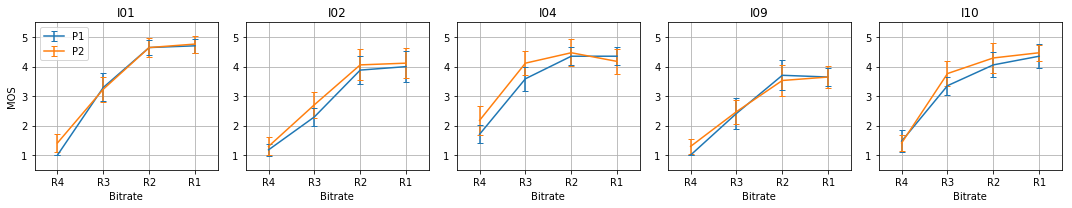

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as ss

# Get a copy of the screened data
df = dfExpDataScreened

images = list(set(df.Image)); images.sort()
bitrates = list(set(df.Bitrate)); bitrates.sort()

# Calculate 95% confidence interval assuming Student's T distribution
def get_ci(xs):
    return ss.t.interval(0.95, len(xs)-1, loc=np.mean(xs),
                         scale=ss.sem(xs)) if ss.sem(xs) > 0 else (np.mean(xs),np.mean(xs))

# Draw a MOS (sub)plot for one LF image
def plot_mos_per_image(im, c = 'P1', n = 0):
    # Retrive data for an image 'im' and codec 'c' and group by bitrate
    xs = list(df[(df['Image'] == im)&(df['Codec'] == c)][['Bitrate','Vote','Codec']].groupby(['Bitrate']))
    # Calculate means for a stimulus data grouped by bitrate earlier
    means = list(map(lambda x: np.mean(x[1]['Vote']), xs))
    #errors = list(map(lambda x: get_ci(x[1]['Vote']), xs)) # Assuming errors
    #errors = list(map(lambda x: (x[1]-x[0])/2, errors))    # .... are symmetric
    errors = list(map(lambda x: abs(get_ci(x[1]['Vote'])-np.mean(x[1]['Vote'])), xs)) # General assymetric case
    errors = list(zip(*errors)) # Re-format the list to feed to matplotlib..errorbar
    x = list(range(len(bitrates),0,-1)) # Reverse the order because R1 is the highest bitrate
    plt.xticks(x, bitrates) # X-axis tick labels
    if n > 0 : plt.subplot(1, 5, n)
    plt.errorbar(x, means, yerr=errors, capsize=3)

# Perform drawing of the plots for MOS with CI
plt.subplots(1,5,figsize=(15,3))
for i,n in zip(images,range(1,6)):
    plot_mos_per_image(i, 'P1', n)
    plot_mos_per_image(i, 'P2', n)
    plt.grid(); plt.title(i)
    plt.ylim((0.5,5.5)); plt.xlim((0.5,4.5))
    plt.xlabel('Bitrate')
    if n==1 :
        plt.ylabel('MOS')
        plt.legend(['P1','P2'])

plt.tight_layout()
plt.savefig("Mos.pdf")
plt.savefig("Mos.png")

plt.show()

## Scripts for interaction analysis


## Read interaction data

In [4]:
# Get subject list (after screening)
subjects = list(set(dfExpDataScreened.Subject))

# Load the score data by subject
def read_tracks(x):
    df = pd.read_csv(data_dir + x + '_tracks.csv')
    df['Subject'] = x
    return df
df = pd.concat([ read_tracks(s) for s in subjects ]).reset_index(drop=True)

# Parce stimulus names to Image, Codec and Bitrate
name_parsed = pd.DataFrame([ [s[:3],s[3:5],s[5:]] for s in df['Stimulus'] ],columns=['Image','Codec','Bitrate'])
df = df.merge(name_parsed,left_index=True, right_index=True)
df = df[['Subject','Stimulus','Image','Codec','Bitrate','Timestamp','x','y']]

#df.to_csv('experiment_data_tracks.csv') # Save the data to CSV

dfTracks = df

print("Number of subjects:",len(subjects))
# dfTracks.head() # Preview data table

Number of subjects: 17


## Calculate interaction vectors 

In [5]:
from multiprocessing import Pool # We will process the data using all the CPUs

df = dfTracks

# Compute an inteaction vector between subsequent views p1(x,y) and p2(x,y)
def get_vector(p1,p2):
    u = 0; v = 0
    if p2.x > p1.x : u = 1
    elif p2.x < p1.x : u = -1      
    if p2.y > p1.y : v = -1   # Reverse the coordinate here
    elif p2.y < p1.y : v = 1  # because Y-axis goes from top to bottom
    return (u,v)

df_out = pd.DataFrame()

xs = list(df.groupby(['Subject','Stimulus']))

def compute_vectors(x):
    df1 = x[1]
    if len(df1) < 2 : # If the length is less than 2 asssuming no interaction
        df1['Time'] = 0
        df1['u'] = 0
        df1['v'] = 0
    else:
        xs1 = list(df1.Timestamp) # Get the timestamps as a list
        # Shift the original list to the right
        xs2 = xs1[1:] # Drop the first element of the list
        xs2.append(xs2[-1]) # Duplicate the last element of the list
        # Compute the difference between adjacent elements of the original list
        df1['Time'] = [(y-x) for x, y in zip(xs1, xs2)] # Time in ms
        
        ps = list(df1[['x','y']].itertuples()) # Iterate over the rows as tuples
        vectors = [get_vector(p1,p2) for p1,p2 in zip(ps[:-1],ps[1:])]
        vectors.append((0,0))
        
        df1['u'] = list(zip(*vectors))[0]
        df1['v'] = list(zip(*vectors))[1]
        df1['Vector'] = vectors
    #if len(df1)<3: print(i,len(df1),set(df1.Subject),set(df1.Stimulus)) # DEBUG
    return df1

# Execute in parallel
if __name__ == '__main__':
    with Pool() as pool:
        df_out = pd.concat(pool.map(compute_vectors,xs))

dfTimeAndVectors = df_out[['Subject','Stimulus','Image','Codec','Bitrate','Timestamp','x','y',
                           'Time','Vector','u','v']]

dfTimeAndVectors.head() # Preview the data frame


,Subject,Stimulus,Image,Codec,Bitrate,Timestamp,x,y,Time,Vector,u,v
10550,1518100656855,I01P1R1,I01,P1,R1,1518101360067,1,0,729,"(1, 0)",1,0
10551,1518100656855,I01P1R1,I01,P1,R1,1518101360796,2,0,148,"(1, 0)",1,0
10552,1518100656855,I01P1R1,I01,P1,R1,1518101360944,3,0,115,"(1, 0)",1,0
10553,1518100656855,I01P1R1,I01,P1,R1,1518101361059,4,0,100,"(1, 0)",1,0
10554,1518100656855,I01P1R1,I01,P1,R1,1518101361159,5,0,150,"(-1, 0)",-1,0


## Plot charts of time spent on a perspertive view

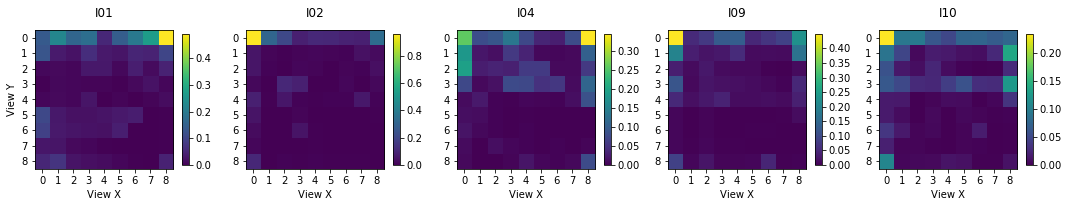

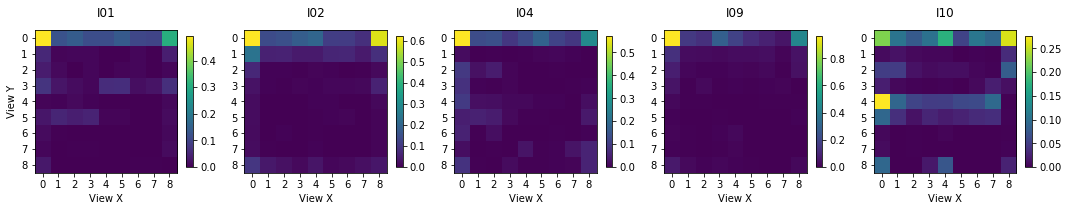

In [6]:
df = dfTimeAndVectors

# Function: Plot plot time spend on each view for a stimulus
# s - stimulus, c - codec, b - bitrate
def plot_sti(s,c,b):
    # Get time values, group by views coordinates, and average by subject
    gr1 = df[(df['Image']==s)&(df.Codec==c)&(df.Bitrate==b)][
        ['Time','x','y']].groupby(['x','y']).sum()/len(subjects)/2
    gr1 = gr1/1000 # change timescale from ms to seconds
    gr2 = gr1.unstack()
    gr2 = gr2.fillna(value=0).transpose() # Fill undefined values with zeroes and transpose
    #print(np.round(gr2,2)) # DEBUG
    plt.matshow(gr2,fignum=False)
    #for (i, j), z in np.ndenumerate(gr2):                            # This code prints
    #    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center') # values in the cells
    plt.gca().xaxis.tick_bottom()
    plt.title(s)
    plt.xlabel('View X');
    
contents = ('I01','I02','I04','I09','I10')

# Make plots for the highest bitrate of codec P1
plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)
for i,n in zip(contents,range(1,len(contents)+1)):
    plt.subplot(1, 5, n)
    plot_sti(i,'P1','R1')
    if n==1 : plt.ylabel('View Y')
    cbar = plt.colorbar(shrink=0.7)
plt.tight_layout()
plt.savefig("interaction_matrices_P1.pdf")

# Make plots for the highest bitrate of codec P2
plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)
for i,n in zip(contents,range(1,len(contents)+1)):
    plt.subplot(1, 5, n)
    plot_sti(i,'P2','R1')
    if n==1 : plt.ylabel('View Y')
    cbar = plt.colorbar(shrink=0.7)
plt.tight_layout()
plt.savefig("interaction_matrices_P2.pdf")

plt.show()


## Plot circular histograms

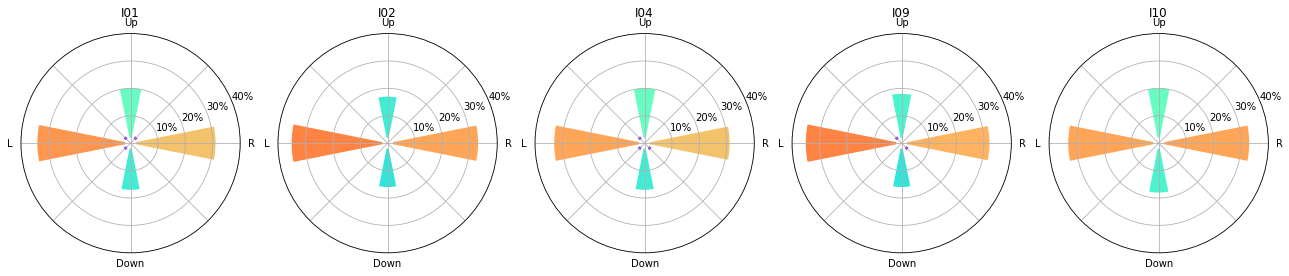

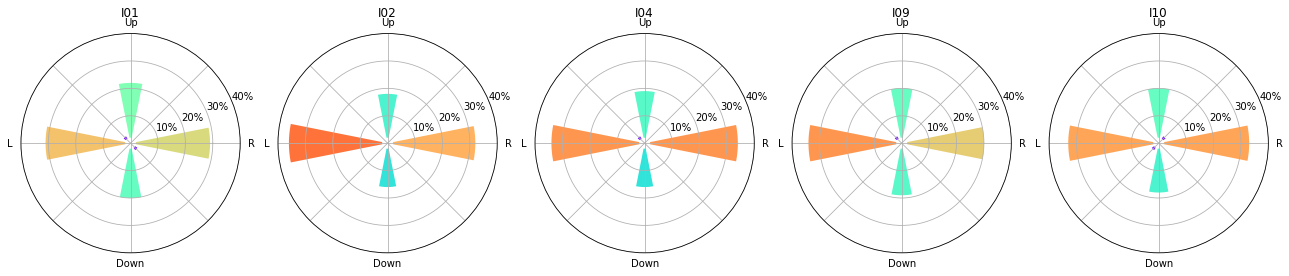

In [7]:
df = dfTimeAndVectors


def plot_windrose(i,c,n):
    df1 = df[(df.Image==i)&(df.Codec==c)]        # Get data for specified content and codec
    dir_list = [( 1, 0),( 1, 1),( 0, 1),(-1, 1), # Order of directions
                (-1, 0),(-1,-1),( 0,-1),( 1,-1)]
    ax = plt.subplot(1, 5, n, polar=True)
    radii = [round(len(df1[df1.Vector==d])/len(df1.Vector)*100) for d in dir_list]
    N = len(radii)
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    width = np.pi/N
    bars = plt.bar(theta, radii, width=width, bottom=2.0)
    for r,bar in zip(radii, bars):
        bar.set_facecolor( plt.cm.rainbow(r/40))
        bar.set_alpha(1.0)
    ax.set_xticklabels(['R','','Up','','L','','Down',''])
    plt.yticks([10,20,30,40], ["10%","20%","30%","40%"])
    plt.ylim(0,40)
    plt.title(i)
    
contents = ('I01','I02','I04','I09','I10')

# Make plots for codec P1
plt.subplots(1,5,figsize=(18,4))
for i,n in zip(contents,range(1,len(contents)+1)):
    plot_windrose(i,'P1',n)
plt.tight_layout()
plt.savefig("direction_charts_P1.pdf")

# Make plots for codec P2
plt.subplots(1,5,figsize=(18,4))
for i,n in zip(contents,range(1,len(contents)+1)):
    plot_windrose(i,'P2',n)
plt.tight_layout()
plt.savefig("direction_charts_P2.pdf")


plt.show()

## Plot average interaction vectors for each perspective view

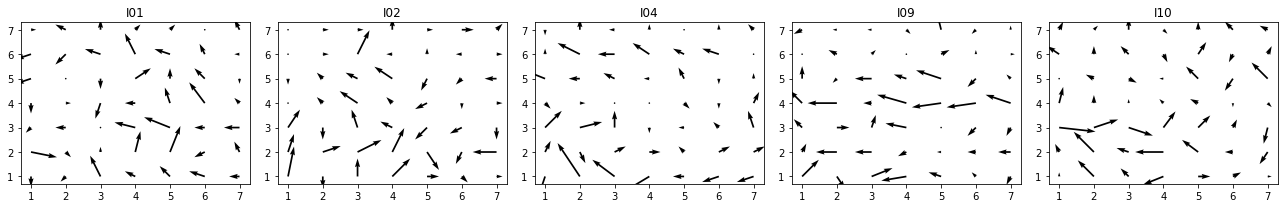

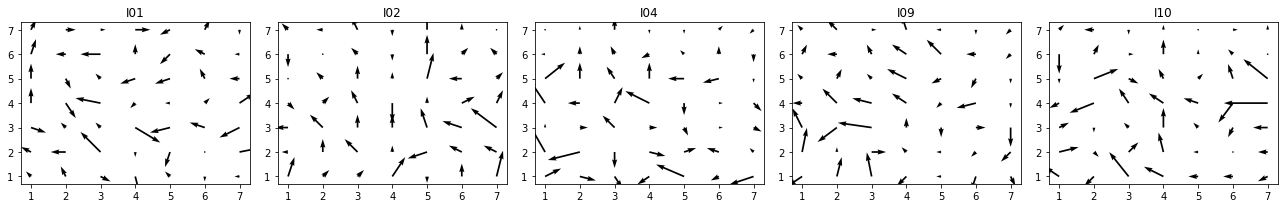

In [8]:
import itertools

df = dfTimeAndVectors

def plot_vects(im,c):
    df1 = df[(df.Image==im)&(df.Codec==c)]
    xys = list(itertools.product(range(1,8),repeat=2))
    us = [ df1[(df1.x==i)&(df1.y==j)]['u'].sum() for (i,j) in xys] # Sum up u coord by view
    vs = [ df1[(df1.x==i)&(df1.y==j)]['v'].sum() for (i,j) in xys] # Sum up v coord by view
    df2 = pd.DataFrame(xys, columns=['x','y']) 
    plt.quiver(df2.x, df2.y, us, vs)
    plt.xticks([1,2,3,4,5,6,7])
    plt.yticks([1,2,3,4,5,6,7])
    plt.title(im)

contents = ('I01','I02','I04','I09','I10')

plt.subplots(1,5,figsize=(18,3),sharex=True,sharey=True)
for i,n in zip(contents,range(1,len(contents)+1)):
    plt.subplot(1, 5, n)
    plot_vects(i,'P1')
plt.tight_layout()
plt.savefig("vectorfield_charts_P1.pdf")

plt.subplots(1,5,figsize=(18,3),sharex=True,sharey=True)
for i,n in zip(contents,range(1,len(contents)+1)):
    plt.subplot(1, 5, n)
    plot_vects(i,'P2')
plt.tight_layout()
plt.savefig("vectorfield_charts_P2.pdf")

plt.show()